* Dataset Link: https://www.kaggle.com/datasets/tongpython/cat-and-dog/
* Put the dataset in a folder named "dataset" in root project directory
* Able to recognize between cats and dogs

In [114]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from PIL import Image

In [115]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(device)

cuda:0


In [116]:
root_dir = './dataset'
train_dir = "./dataset/training_set/training_set"
test_dir = "./dataset/test_set/test_set"

Once the dataset is downloaded from Kaggle, it contains _DS_Store_ alongside the images in both training and test directories, so in the cell below, any non-jpg files are deleted

In [117]:
def delete_non_jpg_files(folder_path):
    for dirpaths, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            if (os.path.splitext(file)[-1] != '.jpg'):
                os.remove(os.path.join(dirpaths, file))
                
delete_non_jpg_files(train_dir)
delete_non_jpg_files(test_dir)

Get the number of classes, and this will be used throughout this notebook.

In [118]:
classes = os.listdir(train_dir)
classes

['cats', 'dogs']

In [119]:
def count_images(label, directory):
    for i in classes:
        result = os.listdir(os.path.join(directory, i))
        print(f"In {label}ing set, there are {len(result)} {i}")
    print("\n")

count_images("Train", train_dir)
count_images("Test", test_dir)

In Training set, there are 4000 cats
In Training set, there are 4005 dogs


In Testing set, there are 1011 cats
In Testing set, there are 1012 dogs




The images have different shapes

In [120]:
first_images = os.listdir(os.path.join(train_dir, "cats"))[:10]
for img in first_images:
    print(mpimg.imread(os.path.join(train_dir, "cats", img)).shape)

(280, 300, 3)
(499, 489, 3)
(499, 403, 3)
(149, 150, 3)
(499, 336, 3)
(407, 379, 3)
(269, 259, 3)
(375, 499, 3)
(333, 500, 3)
(375, 499, 3)


In [121]:
train_transform = T.Compose([
    T.Resize((150,150)),  # making images with the same size
    T.RandomHorizontalFlip(),  # probability=0.5 of flipping
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5],
                [0.5,0.5,0.5])
])

`ImageFolder` is a PyTorch dataset class specifically designed for loading image data when the data is organized in a folder structure where each subfolder represents a different class or category, and the images belonging to each class are stored within their respective subfolders.

In [122]:
def split_data(train_path):
    train_loader = DataLoader(
        torchvision.datasets.ImageFolder(train_path, transform=train_transform),
        batch_size=32,
        shuffle=True,
        drop_last=True
    )
    
    return train_loader
train_loader = split_data(train_dir)

The formula used to calculate the output of the convolution layer.

Formula for size of image in the current layer = $(\frac{(Num of Pixels in Prev Layer+2*Padding-Number Of Pixels In Kernel In H)}{Stride})+1$

* nn.Conv2d(3,64,kernel_size=3, padding=1) where 3 is num of channels, 64 as num of feature maps
    - conv1 output = np.floor(((150+2*1-3)/1))+1 = 150  Shape: (32,64,150,150)
    - after 2x2 maxpool = 150/2 = 75  Shape: (32,64,75,75)
* nn.Conv2d(64,128, kernel_size=3, padding=1) where 64 as output from previous layer, 128 as num of feature maps
    - conv2 output = np.floor( ((75+2*1-3)/1) )+1 = 75  Shape: (32,128,75,75)
    - after 2x2 maxpool = 75/2 = 37  Shape: (32,128,37,37)
* nn.Conv2d(128,256,kernel_size=3,padding=1) where 128 is output from previous layer, 256 as num of feature maps
    - conv3 output = np.floor( ((37+2*1-3)/1) )+1 = 37  Shape: (32,256,37,37)
    - after 2x2 maxpool = 37/2 = 18    Shape: (32,256,18,18)
* fc1 input = output in prev layer * output in prev layer * num of feature maps in prev layer
            = 18x18x256

In [123]:
def create_model():
    class cnn_net(nn.Module):
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(3,64,kernel_size=3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(64)

            self.conv2 = nn.Conv2d(64,128, kernel_size=3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(128)

            self.conv3 = nn.Conv2d(128,256,kernel_size=3,padding=1)
            self.bnorm3 = nn.BatchNorm2d(256)

            self.fc1 = nn.Linear(18*18*256, 100)
            self.fc2 = nn.Linear(100,50)
            self.out = nn.Linear(50,1)
        
        def forward(self,x):
            x = F.max_pool2d(self.conv1(x), 2)
            x = F.relu(self.bnorm1(x))
            
            x = F.max_pool2d(self.conv2(x), 2)
            x = F.relu(self.bnorm2(x))
            
            x = F.max_pool2d(self.conv3(x), 2)
            x = F.relu(self.bnorm3(x))
            
            # reshape for linear layer
            n_units = x.shape.numel()/x.shape[0]
            x = x.view(-1, int(n_units))
            
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.out(x)
    
    net = cnn_net().to(device)
    loss_func = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
    return net, loss_func, optimizer

In [124]:
def train_model(net, loss_func, optimizer, train_loader):
    num_epochs = 17
    train_losses = torch.zeros(num_epochs)
    train_acc = torch.zeros(num_epochs)
    
    for epochi in range(num_epochs):
        net.train()
        batch_acc = []
        batch_losses = []
        for x,y in train_loader:
            x = x.to(device)
            y = y.view(-1, 1).float().to(device)
            
            y_hat = net(x)
            loss = loss_func(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            preds = (torch.sigmoid(y_hat) > 0.5).float()
            batch_acc.append(100*torch.mean( (preds==y).float() ).cpu())
            batch_losses.append(loss.item())
        train_acc[epochi] = torch.tensor(np.mean(batch_acc), dtype=torch.float32)
        train_losses[epochi] = np.mean(batch_losses)
        print(f"Epoch: {epochi+1}/{num_epochs}")
    
    return train_acc, train_losses

In [125]:
net, loss_func, optimizer = create_model()
train_acc, train_losses = train_model(net, loss_func, optimizer, train_loader)

Epoch: 1/17
Epoch: 2/17
Epoch: 3/17
Epoch: 4/17
Epoch: 5/17
Epoch: 6/17
Epoch: 7/17
Epoch: 8/17
Epoch: 9/17
Epoch: 10/17
Epoch: 11/17
Epoch: 12/17
Epoch: 13/17
Epoch: 14/17
Epoch: 15/17
Epoch: 16/17
Epoch: 17/17


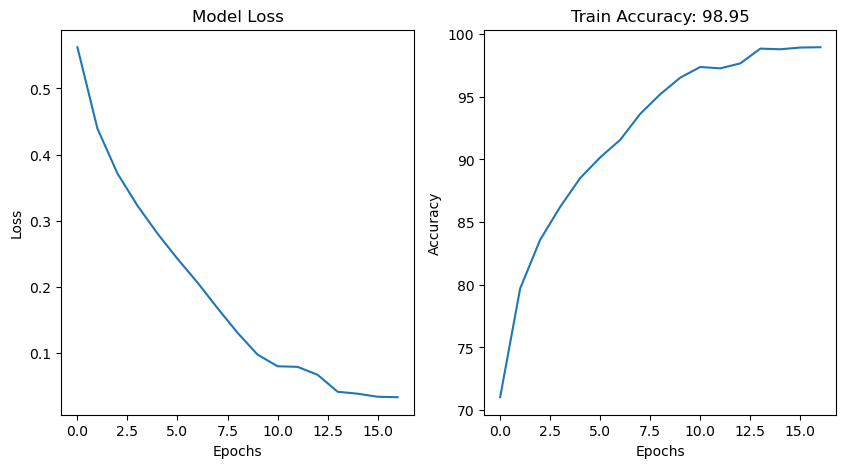

In [126]:
def plot_graph(label, acc, loss):
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].plot(loss, label=label)
    ax[0].set(xlabel="Epochs", ylabel="Loss", title="Model Loss")

    ax[1].plot(acc, label=label)
    ax[1].set(xlabel="Epochs", ylabel="Accuracy", title=f"{label} Accuracy: {acc[-1]:.2f}")
    plt.show()
plot_graph("Train", train_acc, train_losses)

spits out the metrics needed to plot the graph on how the model performed on the test set

In [127]:
def evaluate_test(net, test_loader):
    num_epochs = 17
    test_acc = torch.zeros(num_epochs)
    test_loss = torch.zeros(num_epochs)
    net.eval()
    with torch.no_grad():
        for epochi in range(num_epochs):
            batch_test_acc = []
            batch_test_loss = []
            for x,y in test_loader:
                x = x.to(device)
                y = y.view(-1, 1).float().to(device)
                y_hat = net(x)
                loss = loss_func(y_hat, y)

                preds = (torch.sigmoid(y_hat) > 0.5).float()
                batch_test_acc.append(100*torch.mean( (preds==y).float() ).cpu())
                batch_test_loss.append(loss.item())
            test_acc[epochi] = torch.tensor(np.mean(batch_test_acc), dtype=torch.float32).cpu()
            test_loss[epochi] = np.mean(batch_test_loss)
            print(f"Epoch: {epochi+1}/{num_epochs}")
    return test_acc, test_loss

In [128]:
test_length = len(os.listdir(os.path.join(test_dir, "cats")) + os.listdir(os.path.join(test_dir, "dogs")))

test_transform = T.Compose([
    T.Resize((150,150)),  # making images with the same size
    T.ToTensor(),
    T.Normalize([0.5,0.5,0.5],
                [0.5,0.5,0.5])
])

test_loader = DataLoader(
            torchvision.datasets.ImageFolder(test_dir, transform=test_transform),
            batch_size=32,
            shuffle=True,
            drop_last=True
        )
test_acc, test_loss = evaluate_test(net, test_loader)

Epoch: 1/17
Epoch: 2/17
Epoch: 3/17
Epoch: 4/17
Epoch: 5/17
Epoch: 6/17
Epoch: 7/17
Epoch: 8/17
Epoch: 9/17
Epoch: 10/17
Epoch: 11/17
Epoch: 12/17
Epoch: 13/17
Epoch: 14/17
Epoch: 15/17
Epoch: 16/17
Epoch: 17/17


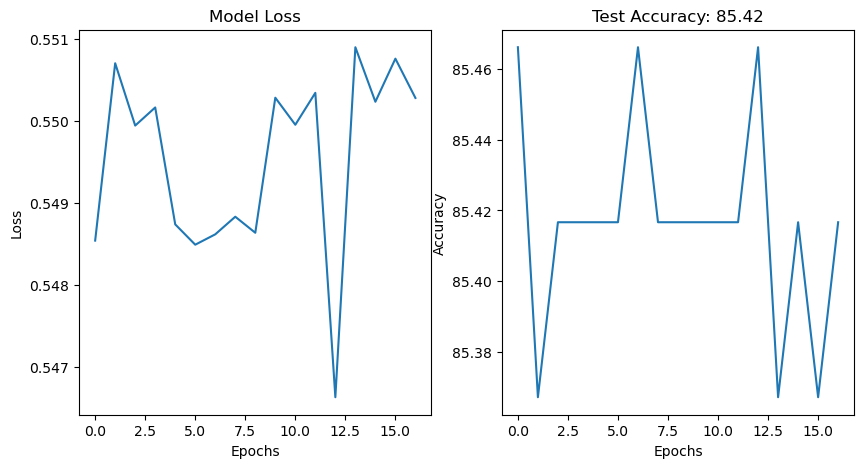

In [129]:
plot_graph("Test", test_acc, test_loss)

Seeing how the model performs on the test set for cat images

In the cell below, in `plot_image`, the first few images are iterated over on the test set and the `predict` function takes an image as one of its parameters to return the prediction.

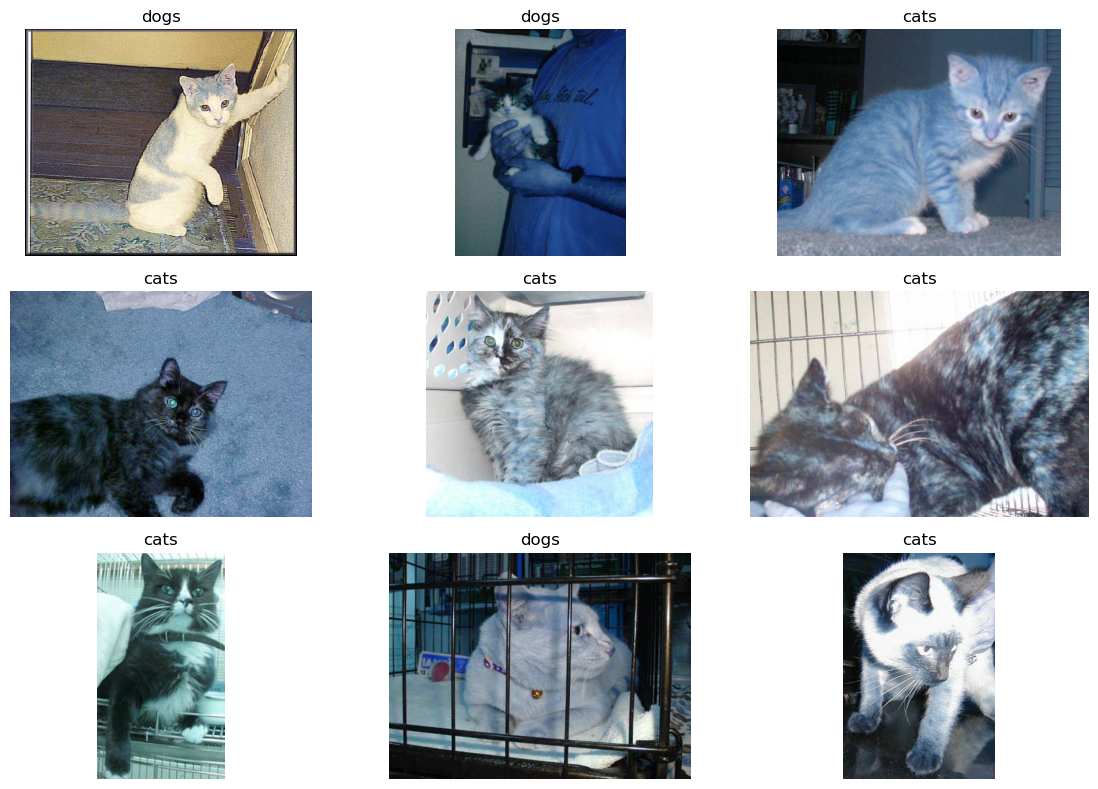

In [132]:
def predict(net, img, test_transform):
    net.eval()
    pil_img = Image.fromarray(img)
    img_tensor = test_transform(pil_img).unsqueeze(0)
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        y_hat = net(img_tensor)
    pred = (torch.sigmoid(y_hat) > 0.5).float()
    return classes[int(pred)]

def plot_images(net, directory, test_transform, images_to_display=9):
    plt.figure(figsize=(12,8))
    images = os.listdir(directory)[:9]
    # enumerate is to add the i
    for i, image in enumerate(images):
        image_path = os.path.join(directory, image)
        img = cv2.imread(image_path)
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        pred = predict(net, img, test_transform)
        plt.title(pred)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    
plot_images(net, os.path.join(test_path, "cats"), test_transform)

Seeing how the model performs on the test set for dog images

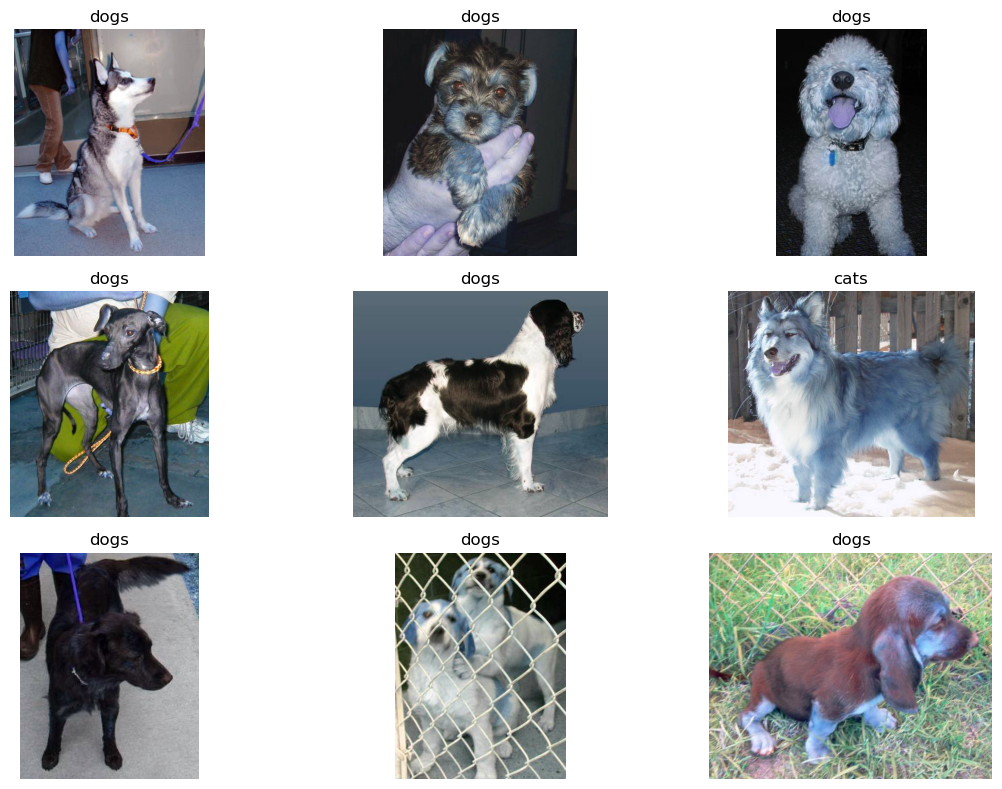

In [133]:
plot_images(net, os.path.join(test_path, "dogs"), test_transform)